# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 37kB/s  eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

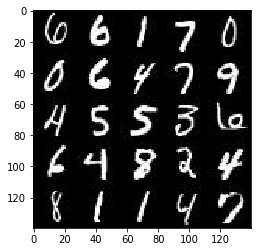

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

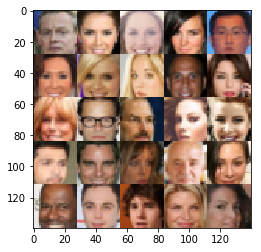

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learn_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return (input_real, input_z, learn_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 832, in start\n    self._run_callback(self._callbacks.popleft())', 'File

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    keep_prob = 0.9
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # Not using batch-norm for the first layer of discriminator
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        # leaky relu
        relu1 = tf.maximum(x1, x1*alpha)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        # batch-norm
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(bn2, bn2*alpha)
        drop2 = tf.nn.dropout(relu2, keep_prob=keep_prob)
        
        x3 = tf.layers.conv2d(drop2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(bn3, bn3*alpha)
        drop3 = tf.nn. dropout(relu3, keep_prob=keep_prob)
        
        # flatten
        flat = tf.reshape(drop3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        
    return (output, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    keep_prob = 0.9
    
    with tf.variable_scope('generator', reuse=not is_train):
        
        x1 = tf.layers.dense(z, 7*7*512, activation=None)
        # Reshape to start convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(bn1, bn1*alpha)
        # 7*7*512
        
        x2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(bn2, bn2*alpha)
        drop2 = tf.nn.dropout(relu2, keep_prob=keep_prob)
        # 14*14*256
        
        x3 = tf.layers.conv2d_transpose(drop2, 128, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(bn3, bn3*alpha)
        drop3 = tf.nn.dropout(relu3, keep_prob=keep_prob)
        # 28*28*128
        
        logits = tf.layers.conv2d_transpose(drop3, out_channel_dim, 3, strides=1, padding='same')
        
        output = tf.tanh(logits)

    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(
                    logits = d_logits_real, 
                    labels = tf.ones_like(d_model_real)*(1-smooth)
                    )
                )
    
    d_loss_fake = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(
                    logits = d_logits_fake,
                    labels = tf.zeros_like(d_model_fake)
                    )
                )
    
    g_loss = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(
                    logits = d_logits_fake,
                    labels = tf.ones_like(d_model_fake)
                    )
                )
    
    d_loss = d_loss_real + d_loss_fake
    
    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get all trainable variables
    t_vars = tf.trainable_variables()
    
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    # tf.control_dependencies controls the execution sequence, 
    # opt will run after tf.GraphKeys.UPDATE_OPS finishes
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # identify the size of image
    _, image_width, image_height, image_channels = data_shape
    
    # inputs and learning rate placeholder
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # calculate loss
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    # optimize
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    saver  = tf.train.Saver()
    steps  = 0
    losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                # Sample random noise for Generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run Optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                
                if steps % 10 == 0:
                    d_train_loss = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    g_train_loss = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}".format(epoch_i+1, epoch_count),
                         "Discriminator Loss: {:.4f}, ".format(d_train_loss),
                         "Generator Loss: {:.4f}".format(g_train_loss))
                    
                    losses.append((d_train_loss, g_train_loss))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                
        saver.save(sess, './checkpoints/generator.ckpt')
        
        return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 Discriminator Loss: 0.3866,  Generator Loss: 3.6601
Epoch 1/2 Discriminator Loss: 0.5135,  Generator Loss: 4.0741
Epoch 1/2 Discriminator Loss: 0.8088,  Generator Loss: 5.2179
Epoch 1/2 Discriminator Loss: 0.5876,  Generator Loss: 6.0698
Epoch 1/2 Discriminator Loss: 2.1393,  Generator Loss: 7.6301
Epoch 1/2 Discriminator Loss: 0.7611,  Generator Loss: 1.6148
Epoch 1/2 Discriminator Loss: 2.0393,  Generator Loss: 0.3404
Epoch 1/2 Discriminator Loss: 1.4319,  Generator Loss: 0.6341
Epoch 1/2 Discriminator Loss: 1.5669,  Generator Loss: 0.5920
Epoch 1/2 Discriminator Loss: 1.4095,  Generator Loss: 0.6747


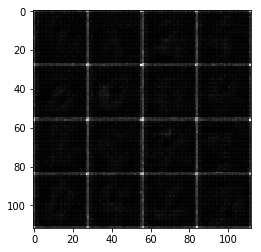

Epoch 1/2 Discriminator Loss: 1.6494,  Generator Loss: 2.0932
Epoch 1/2 Discriminator Loss: 1.2173,  Generator Loss: 1.0786
Epoch 1/2 Discriminator Loss: 1.3022,  Generator Loss: 1.4888
Epoch 1/2 Discriminator Loss: 1.2732,  Generator Loss: 1.3342
Epoch 1/2 Discriminator Loss: 1.6091,  Generator Loss: 0.4327
Epoch 1/2 Discriminator Loss: 1.2944,  Generator Loss: 0.6681
Epoch 1/2 Discriminator Loss: 1.1213,  Generator Loss: 0.7978
Epoch 1/2 Discriminator Loss: 1.2576,  Generator Loss: 0.7130
Epoch 1/2 Discriminator Loss: 1.3545,  Generator Loss: 0.5677
Epoch 1/2 Discriminator Loss: 1.3968,  Generator Loss: 0.5657


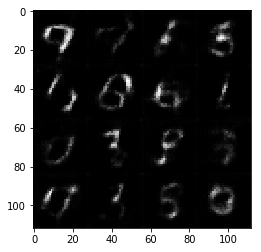

Epoch 1/2 Discriminator Loss: 1.3208,  Generator Loss: 0.6103
Epoch 1/2 Discriminator Loss: 1.1358,  Generator Loss: 0.7259
Epoch 1/2 Discriminator Loss: 1.3643,  Generator Loss: 0.5755
Epoch 1/2 Discriminator Loss: 1.3089,  Generator Loss: 0.6356
Epoch 1/2 Discriminator Loss: 1.1789,  Generator Loss: 0.7836
Epoch 1/2 Discriminator Loss: 1.3029,  Generator Loss: 0.7273
Epoch 1/2 Discriminator Loss: 1.1358,  Generator Loss: 0.7914
Epoch 1/2 Discriminator Loss: 1.5024,  Generator Loss: 0.4721
Epoch 1/2 Discriminator Loss: 1.0817,  Generator Loss: 1.4955
Epoch 1/2 Discriminator Loss: 1.2949,  Generator Loss: 1.2366


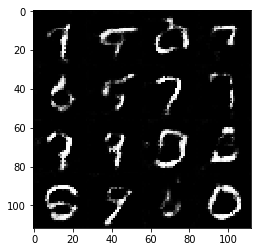

Epoch 1/2 Discriminator Loss: 1.0919,  Generator Loss: 0.9949
Epoch 1/2 Discriminator Loss: 1.2865,  Generator Loss: 0.8601
Epoch 1/2 Discriminator Loss: 1.3192,  Generator Loss: 2.0779
Epoch 1/2 Discriminator Loss: 1.2289,  Generator Loss: 1.6675
Epoch 1/2 Discriminator Loss: 1.3291,  Generator Loss: 1.2473
Epoch 1/2 Discriminator Loss: 1.1175,  Generator Loss: 1.3288
Epoch 1/2 Discriminator Loss: 0.9875,  Generator Loss: 1.3468
Epoch 1/2 Discriminator Loss: 1.5185,  Generator Loss: 0.4856
Epoch 1/2 Discriminator Loss: 0.9129,  Generator Loss: 1.1698
Epoch 1/2 Discriminator Loss: 1.0168,  Generator Loss: 1.6246


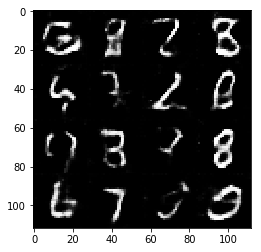

Epoch 1/2 Discriminator Loss: 1.2047,  Generator Loss: 0.9184
Epoch 1/2 Discriminator Loss: 1.2280,  Generator Loss: 0.9991
Epoch 1/2 Discriminator Loss: 1.3147,  Generator Loss: 1.4143
Epoch 1/2 Discriminator Loss: 1.2185,  Generator Loss: 0.8501
Epoch 1/2 Discriminator Loss: 1.2897,  Generator Loss: 1.5248
Epoch 1/2 Discriminator Loss: 1.1476,  Generator Loss: 0.9200
Epoch 2/2 Discriminator Loss: 1.1912,  Generator Loss: 0.8622
Epoch 2/2 Discriminator Loss: 1.2247,  Generator Loss: 0.9525
Epoch 2/2 Discriminator Loss: 1.1759,  Generator Loss: 1.1883
Epoch 2/2 Discriminator Loss: 1.1884,  Generator Loss: 1.1224


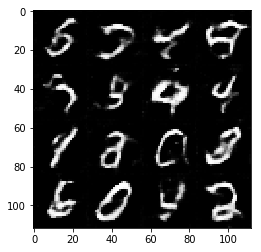

Epoch 2/2 Discriminator Loss: 1.1980,  Generator Loss: 0.8298
Epoch 2/2 Discriminator Loss: 1.1245,  Generator Loss: 0.9052
Epoch 2/2 Discriminator Loss: 1.4077,  Generator Loss: 0.5481
Epoch 2/2 Discriminator Loss: 1.3656,  Generator Loss: 0.5907
Epoch 2/2 Discriminator Loss: 1.1252,  Generator Loss: 1.2193
Epoch 2/2 Discriminator Loss: 1.2286,  Generator Loss: 1.0558
Epoch 2/2 Discriminator Loss: 1.2280,  Generator Loss: 1.4275
Epoch 2/2 Discriminator Loss: 1.2450,  Generator Loss: 0.8073
Epoch 2/2 Discriminator Loss: 1.1755,  Generator Loss: 0.7547
Epoch 2/2 Discriminator Loss: 1.1284,  Generator Loss: 1.0439


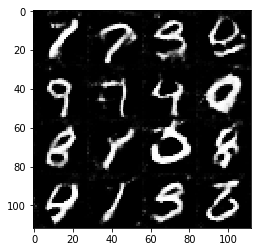

Epoch 2/2 Discriminator Loss: 1.2359,  Generator Loss: 1.0397
Epoch 2/2 Discriminator Loss: 1.1107,  Generator Loss: 1.2165
Epoch 2/2 Discriminator Loss: 1.4934,  Generator Loss: 0.4942
Epoch 2/2 Discriminator Loss: 1.2257,  Generator Loss: 0.7248
Epoch 2/2 Discriminator Loss: 1.4322,  Generator Loss: 1.5786
Epoch 2/2 Discriminator Loss: 1.2115,  Generator Loss: 0.8373
Epoch 2/2 Discriminator Loss: 1.2361,  Generator Loss: 0.7100
Epoch 2/2 Discriminator Loss: 1.2548,  Generator Loss: 0.7330
Epoch 2/2 Discriminator Loss: 1.2594,  Generator Loss: 0.6698
Epoch 2/2 Discriminator Loss: 1.2701,  Generator Loss: 0.7310


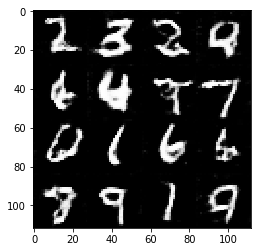

Epoch 2/2 Discriminator Loss: 1.3993,  Generator Loss: 0.5507
Epoch 2/2 Discriminator Loss: 1.2081,  Generator Loss: 0.8123
Epoch 2/2 Discriminator Loss: 1.1016,  Generator Loss: 1.0256
Epoch 2/2 Discriminator Loss: 1.1109,  Generator Loss: 1.0569
Epoch 2/2 Discriminator Loss: 1.3275,  Generator Loss: 0.5876
Epoch 2/2 Discriminator Loss: 1.3399,  Generator Loss: 0.5757
Epoch 2/2 Discriminator Loss: 1.0265,  Generator Loss: 1.1855
Epoch 2/2 Discriminator Loss: 1.2167,  Generator Loss: 0.8868
Epoch 2/2 Discriminator Loss: 1.2140,  Generator Loss: 0.7898
Epoch 2/2 Discriminator Loss: 1.2168,  Generator Loss: 0.7997


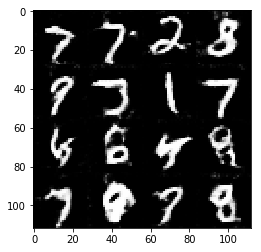

Epoch 2/2 Discriminator Loss: 1.1668,  Generator Loss: 0.9611
Epoch 2/2 Discriminator Loss: 1.2421,  Generator Loss: 1.4618
Epoch 2/2 Discriminator Loss: 1.1841,  Generator Loss: 1.0565
Epoch 2/2 Discriminator Loss: 1.4883,  Generator Loss: 0.4678
Epoch 2/2 Discriminator Loss: 1.0591,  Generator Loss: 0.8305
Epoch 2/2 Discriminator Loss: 1.1736,  Generator Loss: 0.7978
Epoch 2/2 Discriminator Loss: 1.3148,  Generator Loss: 0.7431
Epoch 2/2 Discriminator Loss: 1.2572,  Generator Loss: 1.0295
Epoch 2/2 Discriminator Loss: 1.1799,  Generator Loss: 0.8453
Epoch 2/2 Discriminator Loss: 1.1917,  Generator Loss: 0.7255


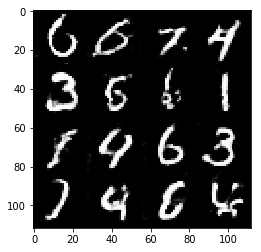

Epoch 2/2 Discriminator Loss: 1.0733,  Generator Loss: 0.9789
Epoch 2/2 Discriminator Loss: 1.1066,  Generator Loss: 1.4895
Epoch 2/2 Discriminator Loss: 1.1952,  Generator Loss: 0.7601


In [12]:
batch_size = 128
z_dim = 128
learning_rate = 0.0004
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    mnist_losses = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

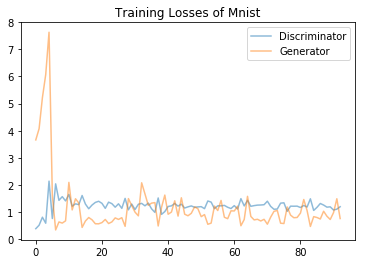

In [14]:
mnist_losses = np.array(mnist_losses)

pyplot.plot(mnist_losses.T[0], label='Discriminator', alpha=0.5)
pyplot.plot(mnist_losses.T[1], label='Generator', alpha=0.5)

pyplot.title("Training Losses of Mnist")
pyplot.legend()

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 Discriminator Loss: 0.5018,  Generator Loss: 2.8835
Epoch 1/1 Discriminator Loss: 0.3716,  Generator Loss: 4.9657
Epoch 1/1 Discriminator Loss: 0.6641,  Generator Loss: 14.9052
Epoch 1/1 Discriminator Loss: 0.4258,  Generator Loss: 14.6922
Epoch 1/1 Discriminator Loss: 1.2813,  Generator Loss: 10.5808
Epoch 1/1 Discriminator Loss: 5.0611,  Generator Loss: 12.0762
Epoch 1/1 Discriminator Loss: 0.5620,  Generator Loss: 2.2335
Epoch 1/1 Discriminator Loss: 0.9830,  Generator Loss: 6.1165
Epoch 1/1 Discriminator Loss: 0.6761,  Generator Loss: 2.3671
Epoch 1/1 Discriminator Loss: 0.4026,  Generator Loss: 5.3391


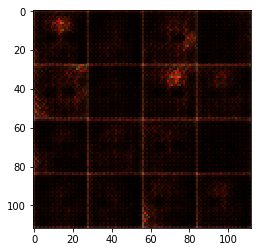

Epoch 1/1 Discriminator Loss: 0.7333,  Generator Loss: 1.4647
Epoch 1/1 Discriminator Loss: 0.5686,  Generator Loss: 2.0310
Epoch 1/1 Discriminator Loss: 0.4635,  Generator Loss: 2.6604
Epoch 1/1 Discriminator Loss: 4.2090,  Generator Loss: 8.8930
Epoch 1/1 Discriminator Loss: 0.6217,  Generator Loss: 2.0356
Epoch 1/1 Discriminator Loss: 0.8401,  Generator Loss: 1.2901
Epoch 1/1 Discriminator Loss: 0.7918,  Generator Loss: 1.3238
Epoch 1/1 Discriminator Loss: 1.0304,  Generator Loss: 1.0325
Epoch 1/1 Discriminator Loss: 1.2373,  Generator Loss: 0.6934
Epoch 1/1 Discriminator Loss: 1.3375,  Generator Loss: 0.6287


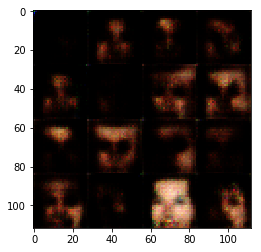

Epoch 1/1 Discriminator Loss: 1.3633,  Generator Loss: 0.5339
Epoch 1/1 Discriminator Loss: 1.1448,  Generator Loss: 0.8508
Epoch 1/1 Discriminator Loss: 1.1884,  Generator Loss: 0.6636
Epoch 1/1 Discriminator Loss: 1.0058,  Generator Loss: 1.5962
Epoch 1/1 Discriminator Loss: 0.9542,  Generator Loss: 1.0781
Epoch 1/1 Discriminator Loss: 1.0507,  Generator Loss: 1.2978
Epoch 1/1 Discriminator Loss: 1.0881,  Generator Loss: 1.9103
Epoch 1/1 Discriminator Loss: 0.9256,  Generator Loss: 1.4942
Epoch 1/1 Discriminator Loss: 1.1011,  Generator Loss: 1.1253
Epoch 1/1 Discriminator Loss: 1.2942,  Generator Loss: 0.5520


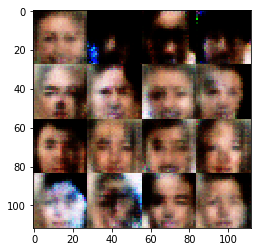

Epoch 1/1 Discriminator Loss: 1.0309,  Generator Loss: 1.1105
Epoch 1/1 Discriminator Loss: 1.2658,  Generator Loss: 0.6581
Epoch 1/1 Discriminator Loss: 1.4651,  Generator Loss: 0.4817
Epoch 1/1 Discriminator Loss: 1.2861,  Generator Loss: 1.1764
Epoch 1/1 Discriminator Loss: 1.5657,  Generator Loss: 2.1145
Epoch 1/1 Discriminator Loss: 1.7864,  Generator Loss: 0.3111
Epoch 1/1 Discriminator Loss: 1.5915,  Generator Loss: 0.4124
Epoch 1/1 Discriminator Loss: 2.2942,  Generator Loss: 2.7895
Epoch 1/1 Discriminator Loss: 1.7881,  Generator Loss: 0.3117
Epoch 1/1 Discriminator Loss: 1.5834,  Generator Loss: 2.0514


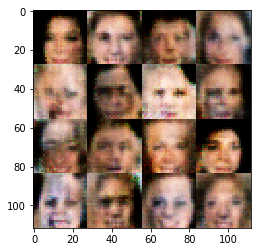

Epoch 1/1 Discriminator Loss: 1.4921,  Generator Loss: 0.5105
Epoch 1/1 Discriminator Loss: 1.0580,  Generator Loss: 1.0011
Epoch 1/1 Discriminator Loss: 0.9964,  Generator Loss: 1.2325
Epoch 1/1 Discriminator Loss: 1.1403,  Generator Loss: 0.9900
Epoch 1/1 Discriminator Loss: 1.4098,  Generator Loss: 0.5459
Epoch 1/1 Discriminator Loss: 1.4861,  Generator Loss: 0.4654
Epoch 1/1 Discriminator Loss: 1.1739,  Generator Loss: 0.8397
Epoch 1/1 Discriminator Loss: 1.0366,  Generator Loss: 1.2498
Epoch 1/1 Discriminator Loss: 1.0881,  Generator Loss: 1.0231
Epoch 1/1 Discriminator Loss: 1.1660,  Generator Loss: 1.4367


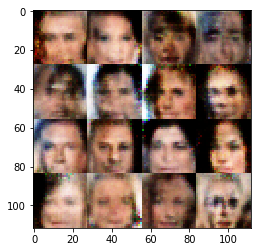

Epoch 1/1 Discriminator Loss: 1.3464,  Generator Loss: 0.5545
Epoch 1/1 Discriminator Loss: 1.2465,  Generator Loss: 0.6365
Epoch 1/1 Discriminator Loss: 1.2988,  Generator Loss: 0.5621
Epoch 1/1 Discriminator Loss: 1.1954,  Generator Loss: 0.7364
Epoch 1/1 Discriminator Loss: 1.3702,  Generator Loss: 0.5485
Epoch 1/1 Discriminator Loss: 2.1075,  Generator Loss: 0.2112
Epoch 1/1 Discriminator Loss: 1.2169,  Generator Loss: 1.0592
Epoch 1/1 Discriminator Loss: 1.1008,  Generator Loss: 0.8701
Epoch 1/1 Discriminator Loss: 1.1575,  Generator Loss: 0.8493
Epoch 1/1 Discriminator Loss: 1.4344,  Generator Loss: 0.4632


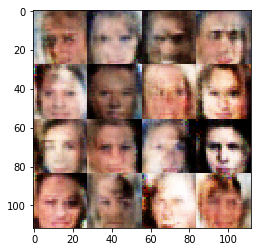

Epoch 1/1 Discriminator Loss: 1.4191,  Generator Loss: 1.9155
Epoch 1/1 Discriminator Loss: 1.4537,  Generator Loss: 0.4702
Epoch 1/1 Discriminator Loss: 1.3446,  Generator Loss: 0.6795
Epoch 1/1 Discriminator Loss: 1.5508,  Generator Loss: 1.9437
Epoch 1/1 Discriminator Loss: 1.6247,  Generator Loss: 0.3897
Epoch 1/1 Discriminator Loss: 1.5838,  Generator Loss: 0.3841
Epoch 1/1 Discriminator Loss: 1.2209,  Generator Loss: 0.8676
Epoch 1/1 Discriminator Loss: 1.6245,  Generator Loss: 0.3628
Epoch 1/1 Discriminator Loss: 2.0540,  Generator Loss: 0.2112
Epoch 1/1 Discriminator Loss: 1.2251,  Generator Loss: 0.8649


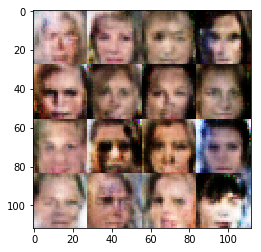

Epoch 1/1 Discriminator Loss: 1.2611,  Generator Loss: 1.3686
Epoch 1/1 Discriminator Loss: 1.3572,  Generator Loss: 0.5630
Epoch 1/1 Discriminator Loss: 1.0596,  Generator Loss: 1.7724
Epoch 1/1 Discriminator Loss: 1.1747,  Generator Loss: 0.7808
Epoch 1/1 Discriminator Loss: 1.0726,  Generator Loss: 1.2332
Epoch 1/1 Discriminator Loss: 1.1749,  Generator Loss: 1.0957
Epoch 1/1 Discriminator Loss: 2.0127,  Generator Loss: 0.2298
Epoch 1/1 Discriminator Loss: 1.2653,  Generator Loss: 1.0034
Epoch 1/1 Discriminator Loss: 1.3855,  Generator Loss: 0.5803
Epoch 1/1 Discriminator Loss: 1.4687,  Generator Loss: 1.7469


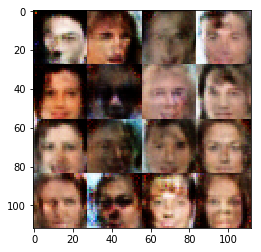

Epoch 1/1 Discriminator Loss: 1.7845,  Generator Loss: 0.3239
Epoch 1/1 Discriminator Loss: 1.3578,  Generator Loss: 0.7143
Epoch 1/1 Discriminator Loss: 1.1856,  Generator Loss: 0.9226
Epoch 1/1 Discriminator Loss: 1.1949,  Generator Loss: 0.6576
Epoch 1/1 Discriminator Loss: 1.8411,  Generator Loss: 0.2963
Epoch 1/1 Discriminator Loss: 1.2660,  Generator Loss: 0.7197
Epoch 1/1 Discriminator Loss: 1.1968,  Generator Loss: 1.1081
Epoch 1/1 Discriminator Loss: 1.2869,  Generator Loss: 0.7582
Epoch 1/1 Discriminator Loss: 1.3181,  Generator Loss: 0.8575
Epoch 1/1 Discriminator Loss: 1.3730,  Generator Loss: 0.6054


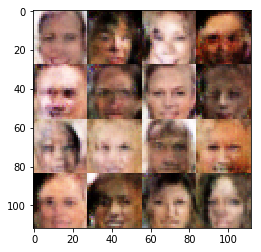

Epoch 1/1 Discriminator Loss: 1.1552,  Generator Loss: 1.3256
Epoch 1/1 Discriminator Loss: 1.4042,  Generator Loss: 0.5004
Epoch 1/1 Discriminator Loss: 1.0886,  Generator Loss: 1.3708
Epoch 1/1 Discriminator Loss: 1.7017,  Generator Loss: 0.3455
Epoch 1/1 Discriminator Loss: 1.2143,  Generator Loss: 0.7934
Epoch 1/1 Discriminator Loss: 1.2712,  Generator Loss: 0.7781
Epoch 1/1 Discriminator Loss: 1.3250,  Generator Loss: 1.2689
Epoch 1/1 Discriminator Loss: 1.4450,  Generator Loss: 0.5311
Epoch 1/1 Discriminator Loss: 1.5776,  Generator Loss: 1.3997
Epoch 1/1 Discriminator Loss: 1.2703,  Generator Loss: 1.1296


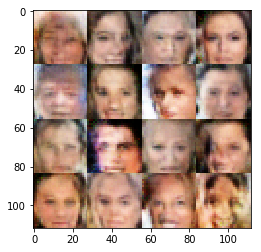

Epoch 1/1 Discriminator Loss: 1.3286,  Generator Loss: 0.8635
Epoch 1/1 Discriminator Loss: 1.3245,  Generator Loss: 0.9375
Epoch 1/1 Discriminator Loss: 1.5042,  Generator Loss: 0.4681
Epoch 1/1 Discriminator Loss: 1.8335,  Generator Loss: 1.1929
Epoch 1/1 Discriminator Loss: 1.8502,  Generator Loss: 0.3048
Epoch 1/1 Discriminator Loss: 1.3624,  Generator Loss: 1.0509
Epoch 1/1 Discriminator Loss: 1.1347,  Generator Loss: 0.9198
Epoch 1/1 Discriminator Loss: 1.2759,  Generator Loss: 0.7680
Epoch 1/1 Discriminator Loss: 1.6320,  Generator Loss: 0.3701
Epoch 1/1 Discriminator Loss: 1.3908,  Generator Loss: 0.5516


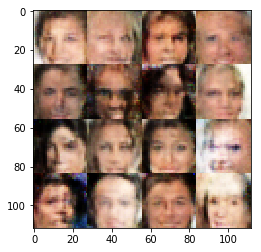

Epoch 1/1 Discriminator Loss: 1.3153,  Generator Loss: 1.2741
Epoch 1/1 Discriminator Loss: 1.3026,  Generator Loss: 0.9010
Epoch 1/1 Discriminator Loss: 1.4784,  Generator Loss: 0.5963
Epoch 1/1 Discriminator Loss: 1.1332,  Generator Loss: 0.9784
Epoch 1/1 Discriminator Loss: 1.4605,  Generator Loss: 1.1369
Epoch 1/1 Discriminator Loss: 1.7377,  Generator Loss: 0.3457
Epoch 1/1 Discriminator Loss: 1.6284,  Generator Loss: 0.4092
Epoch 1/1 Discriminator Loss: 1.3808,  Generator Loss: 0.6631
Epoch 1/1 Discriminator Loss: 1.6054,  Generator Loss: 0.3816
Epoch 1/1 Discriminator Loss: 1.5691,  Generator Loss: 0.4583


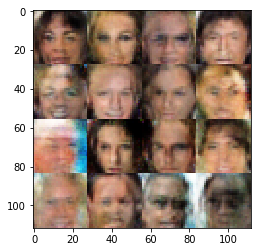

Epoch 1/1 Discriminator Loss: 1.4646,  Generator Loss: 0.6537
Epoch 1/1 Discriminator Loss: 1.4642,  Generator Loss: 0.5314
Epoch 1/1 Discriminator Loss: 1.3192,  Generator Loss: 0.8624
Epoch 1/1 Discriminator Loss: 1.4953,  Generator Loss: 0.4753
Epoch 1/1 Discriminator Loss: 1.4050,  Generator Loss: 0.5695
Epoch 1/1 Discriminator Loss: 1.4165,  Generator Loss: 0.8886
Epoch 1/1 Discriminator Loss: 1.3635,  Generator Loss: 0.7286
Epoch 1/1 Discriminator Loss: 1.4153,  Generator Loss: 0.9385
Epoch 1/1 Discriminator Loss: 1.3709,  Generator Loss: 0.8227
Epoch 1/1 Discriminator Loss: 1.4880,  Generator Loss: 0.5331


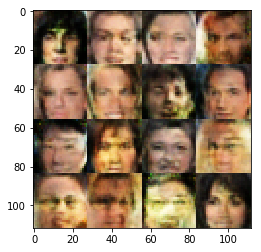

Epoch 1/1 Discriminator Loss: 1.3122,  Generator Loss: 1.1262
Epoch 1/1 Discriminator Loss: 1.4242,  Generator Loss: 0.5108
Epoch 1/1 Discriminator Loss: 1.5732,  Generator Loss: 0.4806
Epoch 1/1 Discriminator Loss: 1.6169,  Generator Loss: 0.4268
Epoch 1/1 Discriminator Loss: 1.4695,  Generator Loss: 0.6374
Epoch 1/1 Discriminator Loss: 1.4936,  Generator Loss: 0.9292
Epoch 1/1 Discriminator Loss: 1.3597,  Generator Loss: 0.9384
Epoch 1/1 Discriminator Loss: 1.4068,  Generator Loss: 0.6328
Epoch 1/1 Discriminator Loss: 1.3114,  Generator Loss: 0.9870
Epoch 1/1 Discriminator Loss: 1.2906,  Generator Loss: 0.9090


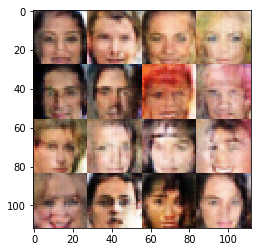

Epoch 1/1 Discriminator Loss: 1.2498,  Generator Loss: 1.0304
Epoch 1/1 Discriminator Loss: 1.3035,  Generator Loss: 0.9858
Epoch 1/1 Discriminator Loss: 1.3599,  Generator Loss: 0.9292
Epoch 1/1 Discriminator Loss: 1.5938,  Generator Loss: 1.0812
Epoch 1/1 Discriminator Loss: 1.3245,  Generator Loss: 0.8094
Epoch 1/1 Discriminator Loss: 1.3151,  Generator Loss: 0.9956
Epoch 1/1 Discriminator Loss: 1.3990,  Generator Loss: 0.7189
Epoch 1/1 Discriminator Loss: 1.4298,  Generator Loss: 0.8224
Epoch 1/1 Discriminator Loss: 1.4175,  Generator Loss: 0.9760
Epoch 1/1 Discriminator Loss: 1.3921,  Generator Loss: 0.7367


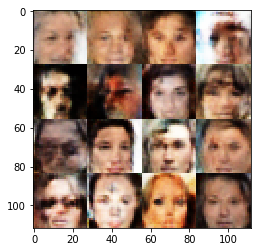

Epoch 1/1 Discriminator Loss: 1.3556,  Generator Loss: 1.2440
Epoch 1/1 Discriminator Loss: 1.3642,  Generator Loss: 0.7454
Epoch 1/1 Discriminator Loss: 1.3499,  Generator Loss: 1.0508
Epoch 1/1 Discriminator Loss: 1.4428,  Generator Loss: 0.9591
Epoch 1/1 Discriminator Loss: 1.3521,  Generator Loss: 1.0244
Epoch 1/1 Discriminator Loss: 1.3647,  Generator Loss: 0.9543
Epoch 1/1 Discriminator Loss: 1.5262,  Generator Loss: 0.4823
Epoch 1/1 Discriminator Loss: 1.3023,  Generator Loss: 0.8681


In [15]:
batch_size = 128
z_dim = 256
learning_rate = 0.0004
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    celeba_losses = train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

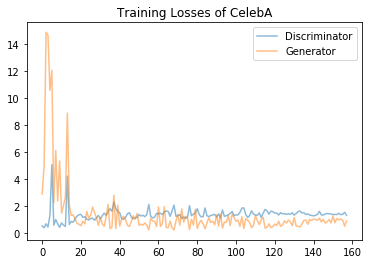

In [16]:
celeba_losses = np.array(celeba_losses)

pyplot.plot(celeba_losses.T[0], label='Discriminator', alpha=0.5)
pyplot.plot(celeba_losses.T[1], label='Generator', alpha=0.5)

pyplot.title("Training Losses of CelebA")
pyplot.legend()

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.